# Problem Set 3 Solutions



## Part 2: Building Neural Networks in TensorFlow

(45 points)

### Q2.1 MLP in TensorFlow

Sample implementation of `mlp()` is given below.

In [4]:
def mlp(x, hidden_sizes, activation_fn=tf.nn.relu):
    if not isinstance(hidden_sizes, (list, tuple)):
        raise ValueError("hidden_sizes must be a list or a tuple")
    last_output = x
    for layer_i, hidden_i in enumerate(hidden_sizes):
        args = {'initializer': tf.random_normal_initializer()}
        with tf.variable_scope("layer_%d" % layer_i, **args):
            input_dim_i = last_output.get_shape()[1].value
            W = tf.get_variable('W', shape=[input_dim_i, hidden_i])
            b = tf.get_variable('b', shape=[hidden_i])
            linear_output = tf.matmul(last_output, W) + b
            is_last_step = layer_i == len(hidden_sizes) - 1
            last_output = (activation_fn(linear_output) 
                           if not is_last_step else linear_output)
    return last_output

In [5]:
test_classification(lambda x: mlp(x, [64, 10], activation_fn=tf.nn.relu), learning_rate=0.1)

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iteration 0	 accuracy: 0.140
iteration 2000	 accuracy: 0.850
iteration 4000	 accuracy: 0.878
iteration 6000	 accuracy: 0.897
iteration 8000	 accuracy: 0.907
iteration 10000	 accuracy: 0.912
iteration 12000	 accuracy: 0.916
iteration 14000	 accuracy: 0.920
iteration 16000	 accuracy: 0.926
iteration 18000	 accuracy: 0.925
iteration 20000	 accuracy: 0.928


### Q2.2 Siamese Network

Sample implementation of `cosine_similarity()` and `build_model()` provided below.

In [6]:
#################################################################
# Inputs: arr1 and arr2 have shape [batch_size, hidden_sizes[-1]]
# Output: return tensor of shape [batch_size, ], the cosine 
#         similarity betwwen arr1 and arr2
# 
# Hint: use tf.l2_normalize, tf.mul, tf.reduce_sum
#################################################################
def cosine_similarity(arr1, arr2):
    arr1_normed = tf.nn.l2_normalize(arr1, dim=1)
    arr2_normed = tf.nn.l2_normalize(arr2, dim=1)
    arr12_mul = tf.multiply(arr1_normed, arr2_normed)
    return tf.reduce_sum(arr12_mul, 1)
    
#################################################################
# Inputs: mlp_args is a dictionary of arguments to the mlp() 
#         function. 
#         Example: mlp_args = {'hidden_sizes':[64, 64, 32]}
#################################################################
def build_model(mlp_args):
    with tf.Graph().as_default() as g:
        with tf.device("/cpu:0"):
            x1 = tf.placeholder(tf.float32, [None, 784])
            x2 = tf.placeholder(tf.float32, [None, 784])
            y = tf.placeholder(tf.float32, [None])

            with tf.variable_scope("siamese") as var_scope:
                x_repr1 = mlp(x1, **mlp_args)  # hidden representation of x1
                var_scope.reuse_variables()    # weight sharing! 
                x_repr2 = mlp(x2, **mlp_args)  # hidden representation of x2
                logits = cosine_similarity(x_repr1, x_repr2)  # similarity
                
            # define scalar: loss 
            losses = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y)
            loss = tf.reduce_mean(losses)
            
            # define vector: y_prob as sigmoid(cosine_similarity)
            y_prob = tf.sigmoid(logits)
            
            # define vector: y_pred as sign(cosine_similarity)
            y_pred = tf.round(y_prob)
            
            # define scalar: accuracy as the fraction of correct predictions
            is_correct_prediction = tf.equal(y_pred, y)
            accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
            
    return {'graph': g, 'inputs': [x1, x2, y], 'pred': y_pred, 'logits': logits,
            'prob': y_prob, 'loss': loss, 'accuracy': accuracy}

Sample training log shown below.

In [8]:
try:
    from itertools import izip as zip
except ImportError:
    print('This is Python 3')

def run_training(model_dict, train_data_iterator, test_full_iter, 
                 train_full_iter, n_iter=1000, print_every=100):
    with model_dict['graph'].as_default():
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.1)
        train_op = optimizer.minimize(model_dict['loss'])
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for iter_i, data_batch in zip(range(n_iter), train_data_iterator):
                batch_feed_dict = dict(zip(model_dict['inputs'], data_batch))
                sess.run(train_op, feed_dict=batch_feed_dict)
                if iter_i % print_every == 0:
                    print_zip_iter = zip([test_full_iter, train_full_iter], ['test', 'train'])
                    for data_iterator, data_name in print_zip_iter:
                        test_batch = next(data_iterator)
                        batch_feed_dict = dict(zip(model_dict['inputs'], test_batch))
                        to_compute = [model_dict['accuracy'], model_dict['loss']]
                        acc_value, loss_val = sess.run(to_compute, batch_feed_dict)
                        fmt = (iter_i, acc_value, loss_val)
                        print(data_name, 'iteration %d\t accuracy: %.3f, loss: %.3f'%fmt)

train_data_iterator = mnist_siamese_dataset_iterator(100, 'train')
test_full_iter = mnist_siamese_dataset_iterator(-1, 'test')
train_full_iter = mnist_siamese_dataset_iterator(-1, 'train')

mlp_args = {'hidden_sizes':[64, 64, 32]}
model = build_model(mlp_args)
run_training(model, train_data_iterator, test_full_iter, train_full_iter)

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
test iteration 0	 accuracy: 0.100, loss: 1.010
Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
train iteration 0	 accuracy: 0.103, loss: 1.007
test iteration 100	 accuracy: 0.103, loss: 0.943
train iteration 100	 accuracy: 0.102, loss: 0.944
test iteration 200	 accuracy: 0.125, loss: 0.869
train iteration 200	 accuracy: 0.127, loss: 0.869
test iteration 300	 accuracy: 0.210, loss: 0.803
trai

## Part 3: Model Variants

(30 points)

Sample implementation and training log provided below, courtesy of `rdarbha@bu.edu`.

In [38]:
# from: rdarbha@bu.edu

import numpy as np

try:
    from itertools import izip as zip
except ImportError:
    print('This is Python 3')

def mlp(x, hidden_sizes, activation_fn=tf.nn.relu):
    if not isinstance(hidden_sizes, (list, tuple)):
        raise ValueError("hidden_sizes must be a list or a tuple")
    h_size = len(hidden_sizes)
    W = tf.get_variable("W0",shape = [784,hidden_sizes[0]])
    b = tf.get_variable("b0",shape = [hidden_sizes[0]])
    x_n = activation_fn(tf.matmul(x,W) + b)
    for i in range(h_size - 1):
        W = tf.get_variable("W"+str(i + 1),shape = [hidden_sizes[i],hidden_sizes[i + 1]])
        b = tf.get_variable("b"+str(i + 1),shape = [hidden_sizes[i + 1]])
        if not (i == h_size - 2):
            x_n = activation_fn(tf.matmul(x_n,W) + b)
    return (tf.matmul(x_n,W) + b)
    
    
# data preparation
def mnist_siamese_dataset_iterator(batch_size, dataset_name):
    assert dataset_name in ['train', 'test']
    assert batch_size > 0 or batch_size == -1 or batch_size == -2 # -1 for entire dataset
    mnist = input_data.read_data_sets('./datasets/mnist/', one_hot=True)
    dataset = getattr(mnist, dataset_name)
    
    while True:
        if batch_size > 0:
            X1, y1 = dataset.next_batch(batch_size)
            X2, y2 = dataset.next_batch(batch_size)
            y = np.argmax(y1, axis=1) == np.argmax(y2, axis=1)
            yield X1, X2, y
        elif batch_size == -2:
            X1 = dataset.images
            y = np.argmax(dataset.labels, axis=1)
            yield X1, X1, y
        else:
            X1 = dataset.images
            idx = np.arange(len(X1))
            np.random.shuffle(idx)
            X2 = X1[idx]
            y1 = dataset.labels
            y2 = y1[idx]
            y = np.argmax(y1, axis=1) == np.argmax(y2, axis=1)
            yield X1, X2, y    
    
def run_training(model_dict, train_data_iterator, test_full_iter, 
                 train_full_iter, visual_test_iter, n_iter=1000, print_every=100, learn_rate=0.1):
    global features
    global labels
    with model_dict['graph'].as_default():
        #optimizer = tf.train.AdamOptimizer(learning_rate = learn_rate)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = learn_rate)
        train_op = optimizer.minimize(model_dict['loss'])
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for iter_i, data_batch in zip(range(n_iter), train_data_iterator):
                batch_feed_dict = dict(zip(model_dict['inputs'], data_batch))
                sess.run(train_op, feed_dict=batch_feed_dict)
                if iter_i % print_every == 0:
                    print_zip_iter = zip([test_full_iter, train_full_iter], ['test', 'train'])
                    for data_iterator, data_name in print_zip_iter:
                        test_batch = next(data_iterator)
                        batch_feed_dict = dict(zip(model_dict['inputs'], test_batch))
                        to_compute = [model_dict['accuracy'], model_dict['loss']]
                        acc_value, loss_val = sess.run(to_compute, batch_feed_dict)
                        fmt = (iter_i, acc_value, loss_val)
                        print(data_name, 'iteration %d\t accuracy: %.3f, loss: %.3f'%fmt)
                        
            visual_test_feed_dict = dict(zip(model_dict['inputs'], next(visual_test_iter)))
            features, labels = sess.run([model_dict['x_repr1'], model_dict['inputs'][2]], feed_dict = visual_test_feed_dict)

features = []
labels = []
train_data_iterator = mnist_siamese_dataset_iterator(100, 'train')
test_full_iter = mnist_siamese_dataset_iterator(-1, 'test')
train_full_iter = mnist_siamese_dataset_iterator(-1, 'train')
tsne_visualize_test_full_iter = mnist_siamese_dataset_iterator(-2, 'test')

def my_build_model(mlp_args):
    with tf.Graph().as_default() as g:
        with tf.device("/cpu:0"):
            x1 = tf.placeholder(tf.float32, [None, 784])
            x2 = tf.placeholder(tf.float32, [None, 784])
            y = tf.placeholder(tf.float32, [None])

            with tf.variable_scope("siamese", tf.random_normal_initializer()) as var_scope:
                x_repr1 = mlp(x1, **mlp_args)  # hidden representation of x1
                var_scope.reuse_variables()    # weight sharing! 
                x_repr2 = mlp(x2, **mlp_args)  # hidden representation of x2
                logits = cosine_similarity(x_repr1, x_repr2)  # similarity
                
            loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = logits))
            y_prob = tf.sigmoid(logits)
            y_pred = tf.sign(logits)
            correct_prediction = tf.equal(tf.nn.relu(y_pred),tf.cast(y, tf.float32))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return {'graph': g, 'inputs': [x1, x2, y], 'pred': y_pred, 'logits': logits,
            'prob': y_prob, 'loss': loss, 'accuracy': accuracy, 'x_repr1': x_repr1, 'x_repr2': x_repr2}

my_mlp_args = {'hidden_sizes':[64, 64, 32], 'activation_fn':tf.nn.relu}  # you can define your own arguments
model = my_build_model(my_mlp_args)
run_training(model, train_data_iterator, test_full_iter, train_full_iter, learn_rate = 0.3, visual_test_iter = tsne_visualize_test_full_iter, n_iter = 10000)


Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
test iteration 0	 accuracy: 0.107, loss: 0.946
Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
train iteration 0	 accuracy: 0.105, loss: 0.950
test iteration 100	 accuracy: 0.640, loss: 0.664
train iteration 100	 accuracy: 0.642, loss: 0.663
test iteration 200	 accuracy: 0.672, loss: 0.660
train iteration 200	 accuracy: 0.680, loss: 0.654
test iteration 300	 accuracy: 0.689, loss: 0.649
trai

## Part 4: Visualize learned features
(25 points)

Sample visualization code and result provided below, courtesy of `rdarbha@bu.edu`.

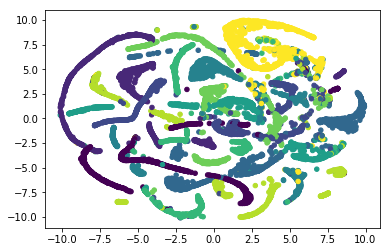

In [39]:
# from: rdarbha@bu.edu

import pylab as Plot
from sklearn.manifold import TSNE

def visualize(features, labels):
    mod = TSNE(n_components=2)
    Y = mod.fit_transform(features) 
    Plot.scatter(Y[:,0], Y[:,1], 20, labels);
    Plot.show();
    
visualize(features, labels)